In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


In [3]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')

# Print the column names
column_names = [desc[0] for desc in cur.description]
print(column_names)
confids = [r[0] for r in results]
molregnos = [r[1] for r in results]
mdfps = [json.loads(r[2]['mdfp']) for r in results]
vps = [r[3] for r in results]


3019 results fetched
['confid', 'molregno', 'mdfp', 'vp']


In [12]:
#disect the mdfps
example = {'2d_counts': [6, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'water_intra_crf': [8.447469879840682, 0.07754269775241597, 8.448101852311458], 'water_intra_lj': [14.698494638650427, 0.35388130931658185, 14.62080608686442], 'water_total_crf': [-20.59946506906263, 8.513642293598433, -18.724968586184893], 'water_total_lj': [-20.978276995376827, 4.06594223290863, -22.954899317973993], 'water_intra_ene': [23.14596451849111, 0.3528157869181612, 23.10431903412804], 'water_total_ene': [-41.57774206443945, 6.698043493291234, -39.76306852550783], 'water_rgyr': [1.4897907974950872, 0.0031876909007386768, 1.4891081418027634], 'water_sasa': [2.433884, 0.007920546, 2.4333215]}
mdfp_keys = list(example.keys())
mdfp_keys_full =[]
features_2d = ['NumHeavyAtoms','NumRotatableBonds','NumN','NumO','NumF','NumP','NumS','NumCl','NumBr','NumI']
for key in mdfp_keys:
    if key != '2d_counts':
        for i in ['mean', 'std', 'median']:
            mdfp_keys_full.append(f'{key}_{i}')
    else:
        mdfp_keys_full.extend(features_2d)
print(mdfp_keys_full,len(mdfp_keys_full))
#now make a df from data that we have
df = pd.DataFrame(results, columns=column_names)
#add the mdfp keys
for i,key in enumerate(mdfp_keys_full):
    df[key] = [mdfps[j][i] for j in range(len(mdfps))]

['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median'] 34


In [15]:
#X_train: df all columns except vp
X_train = df.drop(columns=['vp','confid','molregno','mdfp'])
#y_train: df vp
y_train = df['vp']
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor()
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor()

In [16]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/localhome/cschiebroek/.conda/envs/interpret_ML/lib/python3.11/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/139777502176784/ -->

In [20]:
#But for now, lets move on to the ML part. Lets start with ShuZen's code, but attempting to get it a bit more clean
#Lets start with doing 5 fold cross validation, getting the plot and getting MAE, RMSE and R2
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress


def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue

kf = KFold(5)
X = mdfps
y = vps
num_boost_round = 999
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = ([],[])
rmse_arr , mae_arr = [] , []
feature_importance = []

for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    print(model.get_fscore())
    print(model.get_score(importance_type='gain'))
    print(model.get_score(importance_type='weight'))
    feature_importance.append(model.get_score(importance_type='gain'))

real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)
print('R2: ', r2)



1it [00:09,  9.59s/it]

{'f0': 55.0, 'f1': 34.0, 'f2': 41.0, 'f3': 37.0, 'f4': 21.0, 'f5': 3.0, 'f6': 12.0, 'f7': 10.0, 'f8': 9.0, 'f9': 3.0, 'f10': 57.0, 'f11': 70.0, 'f12': 6.0, 'f13': 63.0, 'f14': 60.0, 'f15': 19.0, 'f16': 34.0, 'f17': 99.0, 'f18': 3.0, 'f19': 62.0, 'f20': 69.0, 'f21': 21.0, 'f22': 23.0, 'f23': 56.0, 'f24': 6.0, 'f25': 19.0, 'f26': 60.0, 'f27': 3.0, 'f28': 60.0, 'f29': 64.0, 'f30': 28.0, 'f31': 52.0, 'f32': 58.0, 'f33': 16.0}
{'f0': 660.3966064453125, 'f1': 20.343460083007812, 'f2': 25.5051212310791, 'f3': 12.920592308044434, 'f4': 34.629764556884766, 'f5': 16.417339324951172, 'f6': 11.29865550994873, 'f7': 8.349943161010742, 'f8': 9.769386291503906, 'f9': 4.433901309967041, 'f10': 4.988000392913818, 'f11': 5.775772571563721, 'f12': 2.9686996936798096, 'f13': 16.493471145629883, 'f14': 8.896038055419922, 'f15': 6.278628349304199, 'f16': 4.696926593780518, 'f17': 57.23347854614258, 'f18': 1.312474250793457, 'f19': 9.010717391967773, 'f20': 32.95259475708008, 'f21': 5.531726360321045, 'f22':

4it [00:14,  2.61s/it]

{'f0': 40.0, 'f1': 20.0, 'f2': 27.0, 'f3': 18.0, 'f4': 18.0, 'f5': 1.0, 'f6': 6.0, 'f7': 5.0, 'f8': 8.0, 'f9': 6.0, 'f10': 23.0, 'f11': 29.0, 'f12': 1.0, 'f13': 21.0, 'f14': 32.0, 'f15': 5.0, 'f16': 10.0, 'f17': 45.0, 'f18': 3.0, 'f19': 33.0, 'f20': 32.0, 'f21': 11.0, 'f22': 10.0, 'f23': 26.0, 'f24': 1.0, 'f25': 7.0, 'f26': 30.0, 'f27': 1.0, 'f28': 38.0, 'f29': 24.0, 'f30': 9.0, 'f31': 15.0, 'f32': 32.0, 'f33': 2.0}
{'f0': 938.4111328125, 'f1': 32.66486358642578, 'f2': 41.50334548950195, 'f3': 15.246891021728516, 'f4': 36.03178405761719, 'f5': 36.99650573730469, 'f6': 10.49354076385498, 'f7': 14.440584182739258, 'f8': 17.639877319335938, 'f9': 11.176369667053223, 'f10': 10.552369117736816, 'f11': 18.112215042114258, 'f12': 9.102076530456543, 'f13': 46.447879791259766, 'f14': 20.637771606445312, 'f15': 46.70356369018555, 'f16': 15.39117431640625, 'f17': 107.37647247314453, 'f18': 17.723493576049805, 'f19': 14.197734832763672, 'f20': 45.54069900512695, 'f21': 16.731157302856445, 'f22': 1

5it [00:14,  2.95s/it]

{'f0': 48.0, 'f1': 17.0, 'f2': 34.0, 'f3': 11.0, 'f4': 18.0, 'f5': 1.0, 'f6': 8.0, 'f7': 11.0, 'f8': 7.0, 'f9': 5.0, 'f10': 30.0, 'f11': 31.0, 'f12': 1.0, 'f13': 14.0, 'f14': 31.0, 'f15': 9.0, 'f16': 9.0, 'f17': 44.0, 'f18': 3.0, 'f19': 27.0, 'f20': 48.0, 'f21': 11.0, 'f22': 6.0, 'f23': 14.0, 'f24': 3.0, 'f25': 7.0, 'f26': 36.0, 'f27': 2.0, 'f28': 37.0, 'f29': 29.0, 'f30': 15.0, 'f31': 17.0, 'f32': 40.0, 'f33': 2.0}
{'f0': 771.2265625, 'f1': 41.72505187988281, 'f2': 40.25181579589844, 'f3': 17.226547241210938, 'f4': 39.50946044921875, 'f5': 6.111440658569336, 'f6': 14.647783279418945, 'f7': 12.98616886138916, 'f8': 12.968838691711426, 'f9': 7.149987697601318, 'f10': 9.368891716003418, 'f11': 11.393735885620117, 'f12': 8.582155227661133, 'f13': 53.57059097290039, 'f14': 12.157295227050781, 'f15': 7.747716426849365, 'f16': 15.03419017791748, 'f17': 96.7585220336914, 'f18': 5.609083652496338, 'f19': 8.306021690368652, 'f20': 34.08644485473633, 'f21': 7.2999587059021, 'f22': 19.54257011413

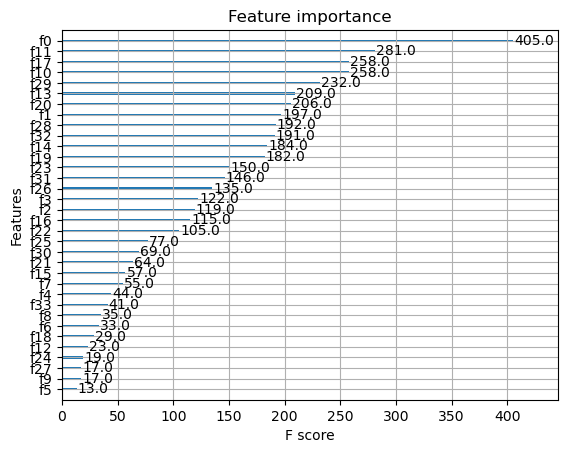

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt
X_train = mdfps
y_train = vps
# Train your XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Plot feature importances
xgb.plot_importance(model, importance_type='weight')  # You can use 'weight', 'gain', or 'cover'
plt.show()
